# Подготовка окружения
Устанавливаем все зависимости, импортируем библиотеки и загружаем данные

In [1]:
import sys

!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_trf

     |████████████████████████████████| 6.0 MB 7.9 MB/s 
     |████████████████████████████████| 10.1 MB 55.0 MB/s 
     |████████████████████████████████| 181 kB 47.6 MB/s 
     |████████████████████████████████| 653 kB 44.8 MB/s 
     |████████████████████████████████| 42 kB 1.7 MB/s 
     |████████████████████████████████| 451 kB 54.1 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4
     |████████████████████████████████| 13.9 M

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import re
from spacy.tokens import DocBin
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# импортируем датасет
raw_df = pd.read_csv("/content/drive/MyDrive/recipes/recipes_82k.csv")
raw_df.head()

,category,cooking_method,cuisine,image,ingredients,prep_time,recipe_name,serves,tags
0,NaN,['Set the racks in the middle and upper thirds...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['1 tablespoons extra virgin olive oil', '1 cu...",20 minutes,Mediterranean Sea Bass,4 servings,"Dairy Free, Gluten Free, Keto Recipes, Kid Fri..."
1,NaN,['Place the eggs in the air fryer basket and c...,['American'],https://www.skinnytaste.com/wp-content/uploads...,"['4 large eggs', 'Salt (black pepper, everythi...",15 minutes,Air Fryer Hard Boiled Eggs,4 eggs,"Air Fryer Recipes, Dairy Free, Gluten Free, Ke..."
2,NaN,"['Air Fryer directions:', 'Preheat air fryer t...",['American'],https://www.skinnytaste.com/wp-content/uploads...,"['olive oil spray', '4 about 5 ounce each salm...",5 minutes,Air Fryer Basil-Parmesan Salmon,4 servings,"Air Fryer Recipes, Gluten Free, Keto Recipes, ..."
3,NaN,"['Preheat the oven to 400F.', 'Pour 2 tablespo...",['American'],https://www.skinnytaste.com/wp-content/uploads...,['1/2 cup freshly grated Parmesan (not pre-gra...,15 minutes,Everything Parmesan Crisps,4 servings,"Gluten Free, Keto Recipes, Kid Friendly, Low C..."
4,NaN,['Cook potatoes in a large pot of salted water...,['American'],https://www.skinnytaste.com/wp-content/uploads...,['3 1/2 pounds new potatoes (about 10 peeled a...,10 minutes,Potato and Green Bean Salad,12 servings,"Dairy Free, Gluten Free, Kid Friendly, Vegetar..."


# Препроцессинг данных

In [5]:
df = raw_df.copy()
# оставляем только колонки с названием кухни и описанием рецепта
df.drop(columns = ['category', 'image', 'ingredients',
                   'prep_time',	'recipe_name',	'serves',	'tags'], inplace = True)

# удаляем пустые значения
df = df[df.cuisine != f'['']']
df = df[df.cooking_method != f'['']']

# делаем из строчек рецепта цельный текст-описание
df.cuisine = df.cuisine.apply(lambda x: x[2:str(x).find(',')-1])
df.cooking_method = df.cooking_method.apply(lambda x: x[2:-2].split('\', \''))
df.cooking_method = df.cooking_method.apply(lambda x:" ".join(x))

df.reset_index(drop=True, inplace = True)
df.cuisine.unique()

array(['American', 'Italian', 'Mexican', 'Chinese', 'Indian', 'Asian',
       'Mediterranean', 'Latin', 'Tex Mex', 'Cuban', 'Brazilian'],
      dtype=object)

Разметка данных оказалось несбалансированной, так что было решено определять не точное название кухни мира для каждого рецепта, а то, из какой части света оно пришло.

In [6]:
north_america = ['American']
south_america = ['Cuban', 'Brazilian', 'Mexican', 'Tex Mex']
europe = ['Latin','Italian', 'Mediterranean']
asia = ['Chinese', 'Indian', 'Asian']
for item in range(len(df)):
  if df.cuisine[item] in north_america:
    df.cuisine[item] = 'North America'
  if df.cuisine[item] in south_america:
    df.cuisine[item] = 'South/Middle America'
  if df.cuisine[item] in europe:
    df.cuisine[item] = 'Europe'
  if df.cuisine[item] in asia:
    df.cuisine[item] = 'Asia'
    
df.cuisine.unique()
classes, count = np.unique(df.cuisine, return_counts= True)

In [7]:
# разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df.cooking_method, df.cuisine, test_size=0.1, random_state=42)

In [8]:
# закодируем метки от 1 до 4

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

# Токенизация данных
Токенизируем тексты, убираем пунктуацию и добавляем лемматизацию.

In [9]:
import string
import re

# загружаем английскую библиотеку из SpaCy
nlp = spacy.load("en_core_web_sm")

# лист со знаками пунктуации и лист слов-исключений из spaCy
punctuations = string.punctuation
stopwords = spacy.lang.en.stop_words.STOP_WORDS
print(stopwords)

def spacy_tokenizer(sentence):
    tokens = nlp(sentence)

    # лемматизируем и убираем слова-исключения
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "PROPN" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]

    return tokens

{'into', 'least', 'whenever', 'mostly', 'against', 'side', 'nine', 'anyway', 'her', 'that', '’re', 'elsewhere', 'perhaps', 'unless', 'next', 'two', 'you', 'alone', 'its', '‘re', 'whereas', 'has', 'would', 'otherwise', 'beyond', 'for', "'re", 'he', 'so', 'will', 'hereafter', 'whereby', 'really', 'were', '’m', 'thereupon', 'become', 'all', 'thus', 'between', 'must', 'thereby', 'than', 'hence', 'what', 'an', 'fifty', 'everything', 'when', 'among', 'i', 'was', '‘m', 'latterly', 'formerly', 'herein', 'does', 'whether', 'bottom', 'sixty', 'through', 'here', 'more', 'seeming', 'should', 'first', 'my', "'d", 'ours', 'afterwards', 'whereupon', 'part', 'twelve', 'give', 'throughout', 'had', 'some', 'while', 'itself', 'hereby', 're', 'themselves', 'at', 'various', 'enough', 'well', '’ve', 'serious', 'then', 'top', 'someone', 'your', 'whoever', 'above', 'them', 'are', 'where', 'hundred', 'onto', 'cannot', 'did', 'below', 'get', 'becoming', 'every', 'make', 'made', 'us', 'move', 'n‘t', "'m", 'up', 

# Bag-of-words
С помощью scikit learn собираем BoW-вектор

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [25]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

# класс-трансформатор для преобработки текста
class cleaner(TransformerMixin):
    def transform(self, X, **transform_params):
        return [text.strip().lower() for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

Далее будем строить пайплайны для различных классификаторов и выведем значения метрик для каждой из них:

## Статистические классификаторы
Обучаем статистические модели (наивный байесовский классификатор, логистическая регрессия, SVM).

In [26]:
# Наивный Байес
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

pipe_NB = Pipeline([("cleaner", cleaner()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# обучаем и предсказываем
pipe_NB.fit(X_train,y_train)
predicted = pipe_NB.predict(X_test)

# выводим метрики
print("Наивный байесовский класификатор :\n")
print(classification_report(y_test, predicted, target_names = ['North America','South/Middle America','Europe','Asia']))

Наивный байесовский класификатор :

                      precision    recall  f1-score   support

       North America       0.82      0.90      0.86        10
South/Middle America       0.42      0.89      0.57         9
              Europe       0.94      0.86      0.90       108
                Asia       0.67      0.55      0.60        11

            accuracy                           0.84       138
           macro avg       0.71      0.80      0.73       138
        weighted avg       0.88      0.84      0.85       138



In [ ]:
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression
classifier_log = LogisticRegression()


pipe_log = Pipeline([("cleaner", cleaner()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier_log)])

pipe_log.fit(X_train,y_train)
predicted_log = pipe_log.predict(X_test)

print("Логистическая регрессия:\n")
print(classification_report(y_test, predicted_log, target_names = ['North America','South/Middle America','Europe','Asia']))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Логистическая регрессия:

                      precision    recall  f1-score   support

       North America       1.00      0.80      0.89        10
South/Middle America       0.29      0.44      0.35         9
              Europe       0.88      0.89      0.88       108
                Asia       0.71      0.45      0.56        11

            accuracy                           0.82       138
           macro avg       0.72      0.65      0.67       138
        weighted avg       0.84      0.82      0.82       138



In [ ]:
# SVM
from sklearn.svm import SVC
classifier_svm = SVC()

pipe_svm = Pipeline([("cleaner", cleaner()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier_svm)])

pipe_svm.fit(X_train,y_train)
predicted_svm = pipe_svm.predict(X_test)

print("Метод опорных векторов:\n")
print(classification_report(y_test, predicted_svm, target_names = ['North America','South/Middle America','Europe','Asia']))

Метод опорных векторов:

                      precision    recall  f1-score   support

       North America       1.00      0.30      0.46        10
South/Middle America       1.00      0.11      0.20         9
              Europe       0.81      1.00      0.89       108
                Asia       0.00      0.00      0.00        11

            accuracy                           0.81       138
           macro avg       0.70      0.35      0.39       138
        weighted avg       0.77      0.81      0.75       138



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Нейросетевые модели
Применим one-hot encoding для каждого класса:

In [ ]:
def preprocess(X, y, embed):

    data = tuple(zip(X.tolist(), y.tolist())) 
    
    # загружаем английскую библиотеку из SpaCy
    nlp=spacy.load(embed)
    docs = []

    # One-hot encoding
    # nlp.pipe возвращает объекты Doc, где атрибут cats хранит словарь
    # с метками и результатами предсказания
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
        doc.cats['north_america'] = 0
        doc.cats['south_america'] = 0
        doc.cats['europe'] = 0
        doc.cats['asia'] = 0
        if label==0:
            doc.cats['asia'] = 1
        elif label==1:
            doc.cats['europe'] = 1
        elif label==2:
            doc.cats['north_america'] = 1
        elif label==3:
            doc.cats['south_america'] = 1
        
        docs.append(doc)
    return docs


Добавляем признаки с классами для тестовой и обучающей выборок и сохраняем на диске для дальнейшего обучения с помощью SpaCy.

In [ ]:
# применяем one-hot encoding к обучающей и тестовой выборкам
train_docs = preprocess(X_train, y_train,"en_core_web_sm")
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("/content/drive/MyDrive/recipes/data/spacy_data/textcat_train.spacy")

test_docs = preprocess(X_test, y_test,"en_core_web_sm")
doc_bin = DocBin(docs=test_docs)
doc_bin.to_disk("/content/drive/MyDrive/recipes/data/spacy_data/textcat_valid.spacy")

  0%|          | 0/1242 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

### Обучение модели

In [ ]:
train_loc = "/content/drive/MyDrive/recipes/data/spacy_data/textcat_train.spacy"
dev_loc = "/content/drive/MyDrive/recipes/data/spacy_data/textcat_valid.spacy"

# загружаем en_core_web_sm и обучающие данные
nlp = spacy.load('en_core_web_sm')
doc_bin = DocBin().from_disk(train_loc)
docs = list(doc_bin.get_docs(nlp.vocab))
entities = 0

for doc in docs:
    entities += len(doc.ents)
print(f"TRAIN docs: {len(docs)} with {entities} entities")

# загружаем тестовые данные
doc_bin = DocBin().from_disk(dev_loc)
docs = list(doc_bin.get_docs(nlp.vocab))
entities = 0

for doc in docs:
    entities += len(doc.ents)
print(f"DEV docs: {len(docs)} with {entities} entities")

TRAIN docs: 1242 with 7427 entities
DEV docs: 138 with 871 entities


Возьмем стандартный конфиг для обучения нейросети (см. rкартинку с инфо из base_config.cfg).
Модель совмещает в себе модуль трансформера (roberta-base) и линейный bag-of-words модуль.

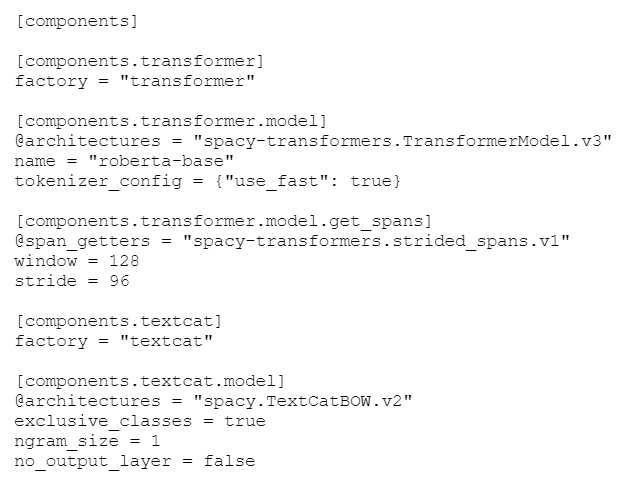

In [ ]:
from IPython.display import Image
Image(filename='/content/drive/MyDrive/spicy_config.png')

In [ ]:
!python -m spacy init fill-config /content/drive/MyDrive/recipes/config/base_config.cfg /content/drive/MyDrive/recipes/config/config.cfg 
!python -m spacy train /content/drive/MyDrive/recipes/config/config.cfg --verbose --output /content/drive/MyDrive/recipes/data/textcat_output --paths.train /content/drive/MyDrive/recipes/data/spacy_data/textcat_train.spacy --paths.dev /content/drive/MyDrive/recipes/data/spacy_data/textcat_valid.spacy

[2022-03-12 10:21:31,917] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev']
ℹ Saving to output directory:
/content/drive/MyDrive/recipes/data/textcat_output
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
[2022-03-12 10:21:34,696] [INFO] Set up nlp object from config
[2022-03-12 10:21:34,708] [DEBUG] Loading corpus from path: /content/drive/MyDrive/recipes/data/spacy_data/textcat_valid.spacy
[2022-03-12 10:21:34,709] [DEBUG] Loading corpus from path: /content/drive/MyDrive/recipes/data/spacy_data/textcat_train.spacy
[2022-03-12 10:21:34,709] [INFO] Pipeline: ['textcat']
[2022-03-12 10:21:34,713] [INFO] Created vocabulary
[2022-03-12 10:21:34,715] [INFO] Finished initializing nlp object
[2022-03-12 10:21:38,627] [INFO] Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
[2022-03-12 10:21:38,639] [DEBUG] Loading corpus from path: /cont

Accuracy получился совсем небольшой - всего 0.43 против ~0.8 на статистических классификаторах.

### Эксперименты

Попробуем проверить насколько хорошо обученная модель справляется с предсказыванием родины рецепта из тестовой выборки, так же проверим на придуманном рецепте:

In [24]:
nlp_model = spacy.load("/content/drive/MyDrive/recipes/data/textcat_output/model-best")
lab_dict = ['asia','europe','north america', 'south america']
test_text = X_test.tolist()
test_cats = y_test.tolist()
doc_test = nlp_model(test_text[20])
print(f"Text: {test_text[20]}")
print(f"Original cuisine: {lab_dict[int(test_cats[20])]}")
print(f"Cuisine probabilities: {doc_test.cats}") 

# проверим рецепт суши
test_sample = 'Prepare rice by mixing cooked short-grain rice with seasoned vinegar. Cut the cucumber and the salmon in small stripes. \
Grab a handful of your prepared rice and place it on the nori. Spread the rice evenly onto nori sheet. \
Now, grab the nori and the bamboo mat together. Roll the bamboo mat over the filling so the extra space at the bottom touches the other side of the nori.'

doc_test = nlp_model(test_sample)
print(f"Text: {test_sample}")
print(f"Original cuisine: asia")
print(f"Cuisine probabilities: {doc_test.cats}") 

Text: In a food processor (or blender should work) blend ricotta and cocoa powder until completely smooth. Transfer to a large bowl. Place egg whites, sugar, salt in a medium heatproof mixing bowl (metal) and place bowl on top of a pot of simmering water. Cook and whisk constantly until the sugar dissolves and the mixture is warm, about 3 minutes. Remove bowl from heat and beat with an electric mixer on high, until stiff peaks form (about 5 minutes). Using a rubber spatula, gently fold egg white mixture into the bowl with ricotta until well combined. Divide into 6 6 oz ramekins or small bowls and refrigerate at least 3 hours.
Original cuisine: north america
Cuisine probabilities: {'north_america': 0.8465431928634644, 'south_america': 0.048587460070848465, 'europe': 0.07360462099313736, 'asia': 0.031264763325452805}
Text: Prepare rice by mixing cooked short-grain rice with seasoned vinegar. Cut the cucumber and the salmon in small stripes. Grab a handful of your prepared rice and place 